<a href="https://colab.research.google.com/github/MikJak75/Neutron_Reflect/blob/main/nr_v12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 125 (delta 4), reused 15 (delta 2), pack-reused 106
Receiving objects: 100% (125/125), 11.36 MiB | 20.01 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [169]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [170]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Dimension of the graphs
in_d1 = 2
in_d2 = 96
#Number of epochs
num_epochs = 120
#Number of layers
num_layers = 1
#Number of neurons
num_neur=150 


In [171]:
cd Neutron_Reflect/

/content/Neutron_Reflect/Neutron_Reflect/Neutron_Reflect


In [172]:
#Stored those numpy arrays
data_path = './data/'
sld_arr = np.load(os.path.join(data_path,'sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'params_fp49.npy'))

In [173]:
sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype

((5942, 2, 96), (5942, 3), dtype('float64'), dtype('float64'))

In [174]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [175]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 96) (4753, 3) (594, 2, 96) (594, 3) (595, 2, 96) (595, 3)


In [176]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [177]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [178]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [179]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/120 	 train loss 0.0755191445350647 	 val loss 0.027417518198490143
EPOCH 2/120 	 train loss 0.0055184816010296345 	 val loss 0.00024946036865003407
EPOCH 3/120 	 train loss 0.00018444722809363157 	 val loss 0.00022676018124911934
EPOCH 4/120 	 train loss 0.0001736190024530515 	 val loss 0.00023618811974301934
EPOCH 5/120 	 train loss 0.00016250782937277108 	 val loss 0.00018797878874465823
EPOCH 6/120 	 train loss 0.00014401691441889852 	 val loss 0.00017814386228565127
EPOCH 7/120 	 train loss 0.00013107409176882356 	 val loss 0.00013850950927007943
EPOCH 8/120 	 train loss 0.00011631089728325605 	 val loss 0.0001203968349727802
EPOCH 9/120 	 train loss 0.00010583398398011923 	 val loss 0.0001094359322451055
EPOCH 10/120 	 train loss 0.00010230615589534864 	 val loss 0.00013612207840196788
EPOCH 11/120 	 train loss 0.00010000114707509056 	 val loss 0.00010554706386756152
EPOCH 12/120 	 train loss 9.257485362468287e-05 	 val loss 9.516291174804792e-05
EPOCH 13/120 	 train loss

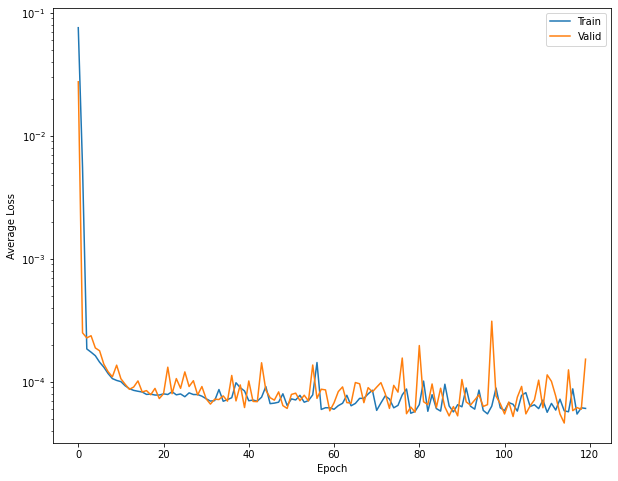

In [180]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 0.00010305680189048871
For image 1, the loss = 0.00014972433564253151
For image 2, the loss = 0.00012090761447325349
For image 3, the loss = 0.0001139020750997588
For image 4, the loss = 0.00016728723130654544
For image 5, the loss = 0.00012476235860958695
For image 6, the loss = 0.00016401286120526493
For image 7, the loss = 0.00012944027548655868
For image 8, the loss = 0.00016912298451643437
For image 9, the loss = 0.0001898701739264652


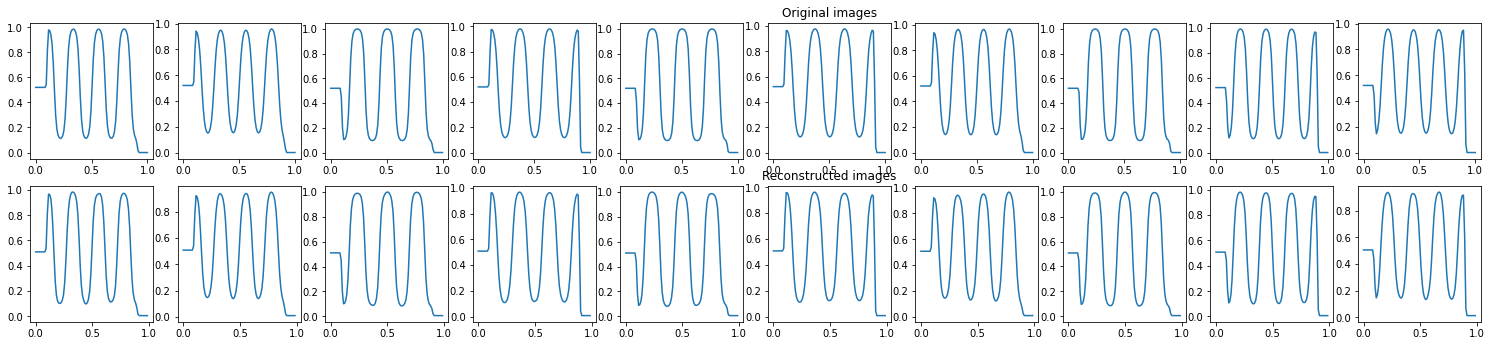

In [181]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

tensor([0.0426, 2.8752, 1.2149])
tensor([2.1883, 0.5516, 2.4313])


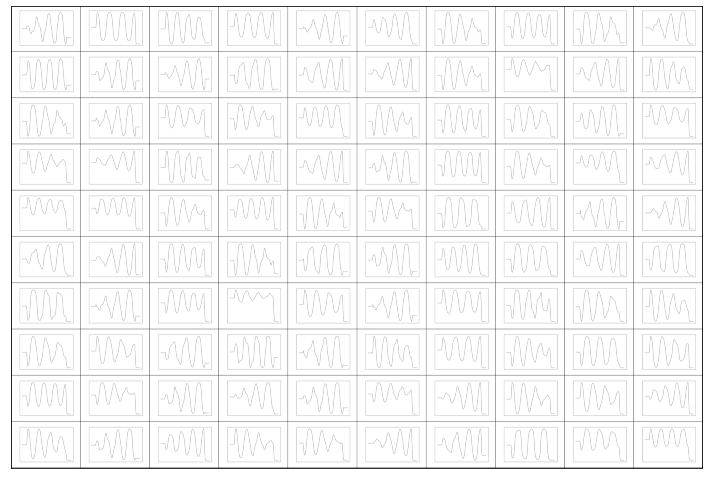

In [182]:
#Interpolating in the latent space
#This is similar to a manifold

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [183]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  print(label_index)

label0
label1
label2


In [184]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,label0,label1,label2
0,-2.390500,3.224978,2.621351,0.143,-0.0239,-0.14198
1,-0.941136,3.492418,-2.341493,0.0963,0.422,-0.20892
2,-2.076533,3.179959,2.544308,0.0719,-0.433,-0.05965
3,3.153934,2.494865,-1.301309,0.191,0.246,0.23462
4,2.204576,2.134062,3.605272,0.14,-0.514,0.13326
...,...,...,...,...,...,...
4748,3.171046,2.486367,-1.267190,0.114,0.459,0.06047
4749,-2.387397,3.227021,2.625404,0.142,-0.169,-0.23644
4750,-1.096622,3.549256,-2.463542,0.144,0.0185,-0.58846
4751,2.171567,2.210238,3.011196,0.0818,0.0159,0.57221


In [185]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 192]) torch.Size([4753, 192]) torch.Size([4753, 3]) torch.Size([4753, 3])
torch.Size([594, 192]) torch.Size([594, 192]) torch.Size([594, 3]) torch.Size([594, 3])
torch.Size([595, 192]) torch.Size([595, 192]) torch.Size([595, 3]) torch.Size([595, 3])


In [186]:
# #Saving encoder and decoder 
# torch.save(encoder.state_dict(),"./encoder.pt")
# torch.save(decoder.state_dict(),"./decoder.pt")

In [187]:
# #Reloading the encoder and decoderen
# encoder.load_state_dict(torch.load("./encoder.pt"))
# decoder.load_state_dict(torch.load("./decoder.pt"))

In [188]:
num_epochs = 600
num_layers = 1
num_neur = 500

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [189]:
# #Running the MLP
# ### Define the loss function 
# loss_fn = torch.nn.MSELoss()

# ### Define the learning rate
# lr= 0.001

# ### Set the random seed for reproducible results
# torch.manual_seed(0)

# #model 
# model = mlp.MLP(dim=d,nlabel=nlabel)
# params_to_optimize = [
#     {'params': model.parameters()}
# ]

# #Define the optimizer
# optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# #Checking the device
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected device: {device}')

In [190]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [191]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/600 	 train loss 0.037196967750787735 	 val loss 0.02384788729250431
EPOCH 2/600 	 train loss 0.02244383655488491 	 val loss 0.02747637778520584
EPOCH 3/600 	 train loss 0.02106284536421299 	 val loss 0.01976311020553112
EPOCH 4/600 	 train loss 0.0199578944593668 	 val loss 0.01962590403854847
EPOCH 5/600 	 train loss 0.019325628876686096 	 val loss 0.022737573832273483
EPOCH 6/600 	 train loss 0.01828516088426113 	 val loss 0.01773691363632679
EPOCH 7/600 	 train loss 0.017879603430628777 	 val loss 0.018481604754924774
EPOCH 8/600 	 train loss 0.017262868583202362 	 val loss 0.018268289044499397
EPOCH 9/600 	 train loss 0.017051810398697853 	 val loss 0.018286239355802536
EPOCH 10/600 	 train loss 0.01664859615266323 	 val loss 0.019080469384789467
EPOCH 11/600 	 train loss 0.016114672645926476 	 val loss 0.01521621085703373
EPOCH 12/600 	 train loss 0.015684081241488457 	 val loss 0.01779729314148426
EPOCH 13/600 	 train loss 0.015451976098120213 	 val loss 0.01707149296998

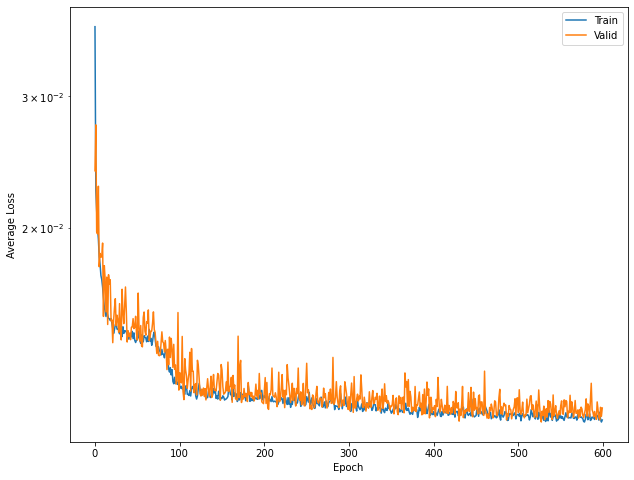

In [192]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [193]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.074336,0.013257,0.435778,0.08,-0.0385,0.56027
1,0.154712,-0.211857,0.503423,0.183,-0.0502,0.46749
2,0.077552,-0.323215,0.357853,0.0814,-0.424,0.40422
3,0.069707,-0.179632,-0.562618,0.077,-0.113,-0.57221
4,0.154987,0.478148,-0.290395,0.194,0.574,-0.12582
...,...,...,...,...,...,...
590,0.158777,0.332027,0.258752,0.132,0.572,0.43457
591,0.155117,0.509441,0.079943,0.195,0.526,0.08113
592,0.153825,0.488292,-0.237540,0.189,0.596,-0.59817
593,0.138403,-0.403057,-0.181746,0.107,-0.303,-0.03922


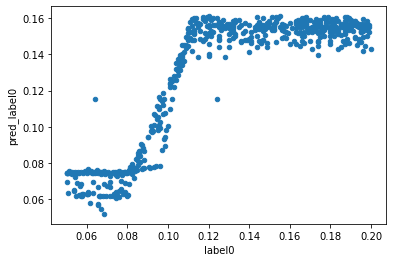

In [194]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

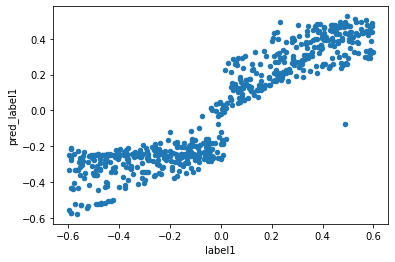

In [195]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

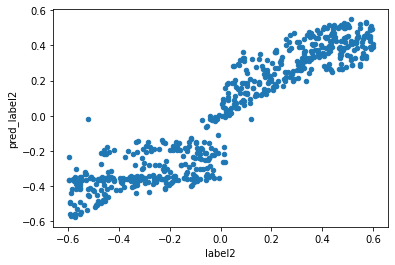

In [196]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [197]:
#Saving data into GitHub

# torch.save(train_latent_var,os.path.join(data_path,'train_latent_var.pt'))
# torch.save(train_latent_var,'train_labels_var.pt')

# torch.save(valid_latent_var,'valid_latent_var.pt')
# torch.save(valid_latent_var,'valid_labels_var.pt')

# torch.save(test_latent_var,'test_latent_var.pt')
# torch.save(test_latent_var,'test_labels_var.pt')


# torch.save(mlp_train_loader,'mlp_train_loader.pth')
# torch.save(mlp_valid_loader,'mlp_valid_loader.pth')
# torch.save(mlp_test_loader,'mlp_test_loader.pth')

# !mv mlp_train_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_valid_loader.pth /content/drive/MyDrive/neutron_reflectivity/
# !mv mlp_test_loader.pth /content/drive/MyDrive/neutron_reflectivity/

# torch.save(mlp_test_dataset,'mlp_test_dataset.pth')
# !mv mlp_test_dataset.pth /content/drive/MyDrive/neutron_reflectivity/

# #Saving also the pandas dataframe for the encoded sample

# #Having issues with the way a saved .csv and loaded one look like. 
# # df_encoded_samples.to_csv('encoded.csv', sep ='\t')
# # !mv encoded.csv /content/drive/MyDrive/neutron_reflectivity/

# #Using pickle instead.
# df_encoded_samples.to_pickle('df_encoded_samples.pkl')
# !mv df_encoded_samples.pkl /content/drive/MyDrive/neutron_reflectivity/

In [198]:
#Testing the model in experimental data
#Stored those numpy arrays
data_path = './exptdata/'

#Functions to read the sld and the param files
def read_sld_files(file_name):
    print(file_name)
    with open(file_name, 'r') as data:
        x = []
        y = []
        xy = [x,y]
        for line in data:
            p = line.split()
            # print(p)
            x.append(float(p[0]))
            y.append(float(p[1]))
            xy = x,y
            # array_xy = np.asarray(xy)

    return np.asarray(x),np.asarray(y)


folder = data_path


datafiles = [os.path.join(root, filename)
          for root, dirs, files in os.walk(folder)
          for filename in files
          if filename.lower().startswith('sld')]

for file in datafiles:
  dataindiv = read_sld_files(file)

dataindiv
# sld_arr = np.load(os.path.join(data_path,'sld_fp49.npy'))
# params_arr = np.load(os.path.join(data_path,'params_fp49.npy'))

./exptdata/sld_data.txt


(array([   0.    ,   19.7887,   39.5773,   59.366 ,   79.1546,   98.9433,
         118.732 ,  138.521 ,  158.309 ,  178.098 ,  197.887 ,  217.675 ,
         237.464 ,  257.253 ,  277.041 ,  296.83  ,  316.619 ,  336.407 ,
         356.196 ,  375.984 ,  395.773 ,  415.562 ,  435.35  ,  455.139 ,
         474.928 ,  494.716 ,  514.505 ,  534.294 ,  554.082 ,  573.871 ,
         593.66  ,  613.448 ,  633.237 ,  653.026 ,  672.814 ,  692.603 ,
         712.392 ,  732.18  ,  751.969 ,  771.758 ,  791.546 ,  811.335 ,
         831.124 ,  850.912 ,  870.701 ,  890.49  ,  910.278 ,  930.067 ,
         949.856 ,  969.644 ,  989.433 , 1009.22  , 1029.01  , 1048.8   ,
        1068.59  , 1088.38  , 1108.16  , 1127.95  , 1147.74  , 1167.53  ,
        1187.32  , 1207.11  , 1226.9   , 1246.69  , 1266.47  , 1286.26  ,
        1306.05  , 1325.84  , 1345.63  , 1365.42  , 1385.21  , 1404.99  ,
        1424.78  , 1444.57  , 1464.36  , 1484.15  , 1503.94  , 1523.73  ,
        1543.52  , 1563.3   , 1583.09 

In [199]:
print(len(datafiles))
print(type(dataindiv[0]))
dataindiv[1].shape


1
<class 'numpy.ndarray'>


(96,)

In [200]:
dataindv_arr = np.asarray(dataindiv)
# dataindv_arr.shape

exp_sld = []
exp_sld.append(dataindv_arr)
#dataindv_arr[0] = dataindv_arr[0] + 250
exp_sld_arr = np.asarray(exp_sld)
exp_sld_arr.shape

print(dataindv_arr.shape)
#dataindv_arr[0] = dataindv_arr[0] + 250
dataindv_arr[0]

(2, 96)


array([   0.    ,   19.7887,   39.5773,   59.366 ,   79.1546,   98.9433,
        118.732 ,  138.521 ,  158.309 ,  178.098 ,  197.887 ,  217.675 ,
        237.464 ,  257.253 ,  277.041 ,  296.83  ,  316.619 ,  336.407 ,
        356.196 ,  375.984 ,  395.773 ,  415.562 ,  435.35  ,  455.139 ,
        474.928 ,  494.716 ,  514.505 ,  534.294 ,  554.082 ,  573.871 ,
        593.66  ,  613.448 ,  633.237 ,  653.026 ,  672.814 ,  692.603 ,
        712.392 ,  732.18  ,  751.969 ,  771.758 ,  791.546 ,  811.335 ,
        831.124 ,  850.912 ,  870.701 ,  890.49  ,  910.278 ,  930.067 ,
        949.856 ,  969.644 ,  989.433 , 1009.22  , 1029.01  , 1048.8   ,
       1068.59  , 1088.38  , 1108.16  , 1127.95  , 1147.74  , 1167.53  ,
       1187.32  , 1207.11  , 1226.9   , 1246.69  , 1266.47  , 1286.26  ,
       1306.05  , 1325.84  , 1345.63  , 1365.42  , 1385.21  , 1404.99  ,
       1424.78  , 1444.57  , 1464.36  , 1484.15  , 1503.94  , 1523.73  ,
       1543.52  , 1563.3   , 1583.09  , 1602.88  , 

[0.         0.01052635 0.02105265 0.031579   0.0421053  0.05263165
 0.06315801 0.07368452 0.0842105  0.09473701 0.10526352 0.1157895
 0.12631601 0.13684253 0.14736851 0.15789502 0.16842153 0.17894751
 0.18947402 0.2        0.21052651 0.22105302 0.231579   0.24210552
 0.25263203 0.26315801 0.27368452 0.28421103 0.29473701 0.30526352
 0.31579003 0.32631601 0.33684253 0.34736904 0.35789502 0.36842153
 0.37894804 0.38947402 0.40000053 0.41052704 0.42105302 0.43157954
 0.44210605 0.45263203 0.46315854 0.47368505 0.48421103 0.49473754
 0.50526405 0.51579003 0.52631655 0.53684199 0.54736904 0.55789608
 0.56842312 0.57895017 0.58947189 0.59999894 0.61052598 0.62105302
 0.63158007 0.64210711 0.65263415 0.6631612  0.67368292 0.68420997
 0.69473701 0.70526405 0.7157911  0.72631814 0.73684518 0.74736691
 0.75789395 0.768421   0.77894804 0.78947508 0.80000213 0.81052917
 0.82105622 0.83157794 0.84210498 0.85263203 0.86315907 0.87368611
 0.88421316 0.8947402  0.90526193 0.91578897 0.92631601 0.93684

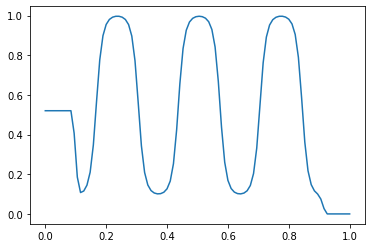

In [201]:
plt.plot(sld_arr[0][0],sld_arr[0][1])
print(sld_arr[0][0])

#transfrom at 0.085

In [202]:
#Normalizing the sld curves by min/max

#First finding the min/max
x_val=sld_arr[:,0,:]
x_min = x_val.min()
x_max = x_val.max()
print('x-range = ', x_min, ' to ',x_max)
y_val=sld_arr[:,1,:]
y_min = y_val.min()
y_max = y_val.max()
print('y-range = ', y_min, ' to ',y_max)

x-range =  0.0  to  1.0
y-range =  0.0  to  1.0


In [203]:
#Normalize
sld_arr[:,0,:] = (sld_arr[:,0,:] - x_min)/(x_max - x_min)
sld_arr[:,1,:] = (sld_arr[:,1,:] - y_min)/(y_max - y_min)

In [204]:
sld_arr.min(), sld_arr.max()

(0.0, 1.0)

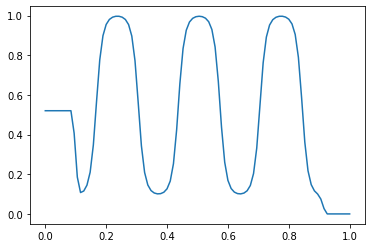

In [205]:
plt.plot(sld_arr[0][0],sld_arr[0][1])

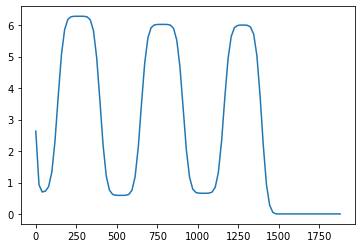

In [206]:
plt.plot(exp_sld_arr[0][0],exp_sld_arr[0][1])

In [207]:
x_val=exp_sld_arr[:,0,:]
x_min = x_val.min()
x_max = x_val.max()
print('x-range = ', x_min, ' to ',x_max)
y_val=exp_sld_arr[:,1,:]
y_min = y_val.min()
y_max = y_val.max()
print('y-range = ', y_min, ' to ',y_max)

exp_sld_arr[:,0,:] = (exp_sld_arr[:,0,:] - x_min)/(x_max - x_min)
exp_sld_arr[:,1,:] = (exp_sld_arr[:,1,:] - y_min)/(y_max - y_min)

type(exp_sld_arr)

x-range =  0.0  to  1879.92
y-range =  0.00808414  to  6.2808628569


numpy.ndarray

In [208]:
encoder.eval().to(device)

Encoder(
  (encoder): Sequential(
    (0): Linear(in_features=192, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=150, out_features=3, bias=True)
  )
)

In [209]:
decoder.eval().to(device)

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=150, out_features=192, bias=True)
  )
)

In [210]:
img = torch.from_numpy(exp_sld_arr).float()
img = img.view(img.size(0), -1).to(device)

In [211]:
encoder.eval()
decoder.eval()
with torch.no_grad(): 
  latent = encoder(img)
  decoded_img = decoder(latent)


[array([0.09      , 0.10052636, 0.11105265, 0.12157901, 0.1321053 ,
       0.14263165, 0.15315801, 0.16368452, 0.1742105 , 0.18473701,
       0.19526353, 0.2057895 , 0.21631601, 0.22684252, 0.23736851,
       0.24789502, 0.25842154, 0.2689475 , 0.27947402, 0.29000002,
       0.3005265 , 0.31105304, 0.321579  , 0.33210552, 0.34263203,
       0.353158  , 0.36368454, 0.37421104, 0.384737  , 0.39526352,
       0.40579003, 0.416316  , 0.42684254, 0.43736905, 0.44789502,
       0.45842153, 0.46894804, 0.47947404, 0.49000055, 0.500527  ,
       0.511053  , 0.5215795 , 0.53210604, 0.54263204, 0.5531585 ,
       0.56368506, 0.574211  , 0.58473754, 0.5952641 , 0.60579   ,
       0.61631656, 0.626842  , 0.63736904, 0.64789605, 0.6584232 ,
       0.6689502 , 0.67947185, 0.689999  , 0.700526  , 0.711053  ,
       0.72158   , 0.73210716, 0.7426342 , 0.7531612 , 0.76368296,
       0.77421   , 0.784737  , 0.795264  , 0.80579114, 0.81631815,
       0.82684517, 0.83736694, 0.84789395, 0.85842097, 0.8689

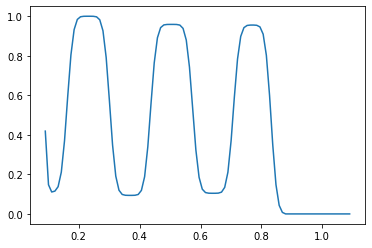

In [212]:
img_arr = img.cpu().reshape(in_d1,in_d2).numpy()
img_arr_trans = list(img_arr)
img_arr_trans[0] = img_arr_trans[0] + 0.09

plt.plot(img_arr_trans[0],img_arr_trans[1]) 
print(img_arr_trans)

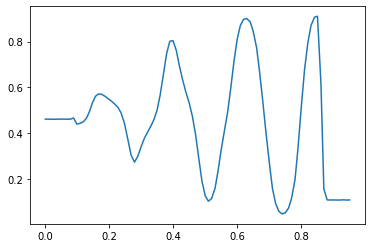

In [213]:
plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 


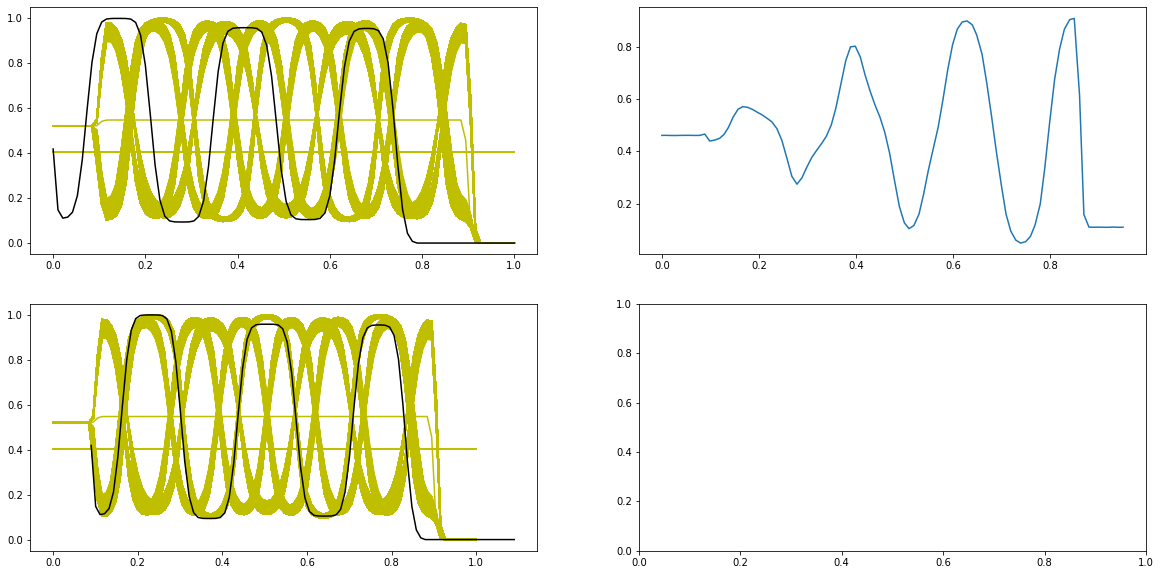

In [214]:
plt.rcParams['figure.figsize'] = [20, 10]

figure, axis = plt.subplots(2,2)

#f1 = plt.figure(1)
for x in range(sld_arr.shape[0]):
  axis[0][0].plot(sld_arr[x][0], sld_arr[x][1], 'y')
axis[0][0].plot(img_arr[0], img_arr[1], 'k')

#f2 = plt.figure(2)
axis[0][1].plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 

for x in range(sld_arr.shape[0]):
  axis[1][0].plot(sld_arr[x][0], sld_arr[x][1], 'y')
axis[1][0].plot(img_arr_trans[0], img_arr_trans[1], 'k')

#figure, axis = plt.subplots(1, 2)
#axis[0].plot(f1)
#axis[1].plot(f2)

plt.show()

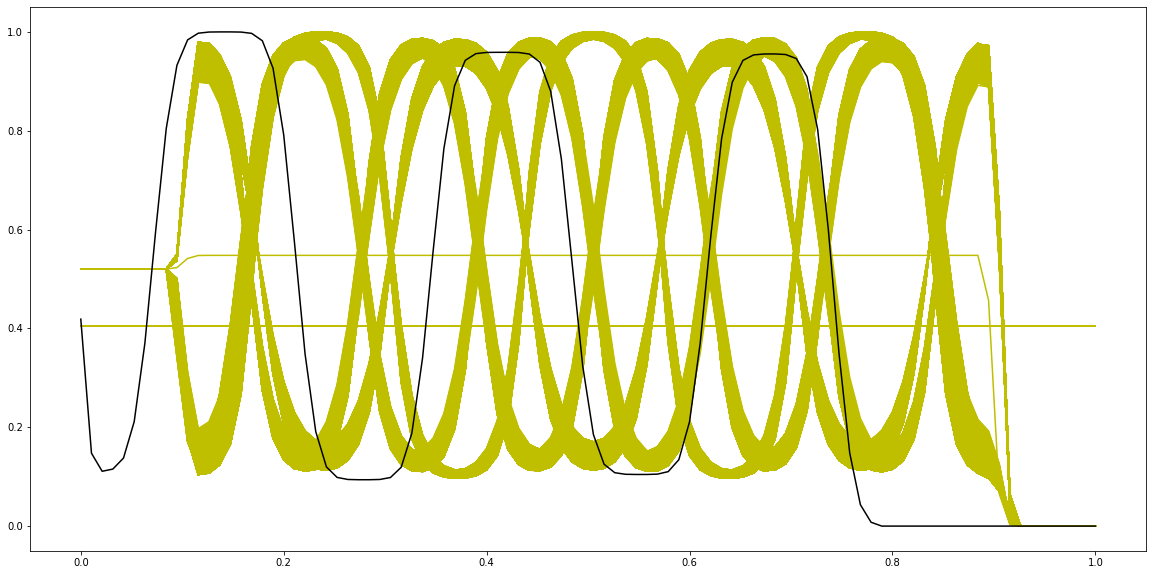

In [215]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0], sld_arr[x][1], 'y')
plt.plot(exp_sld_arr[0][0], exp_sld_arr[0][1], 'k')
#plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1], 'k') 
plt.show()

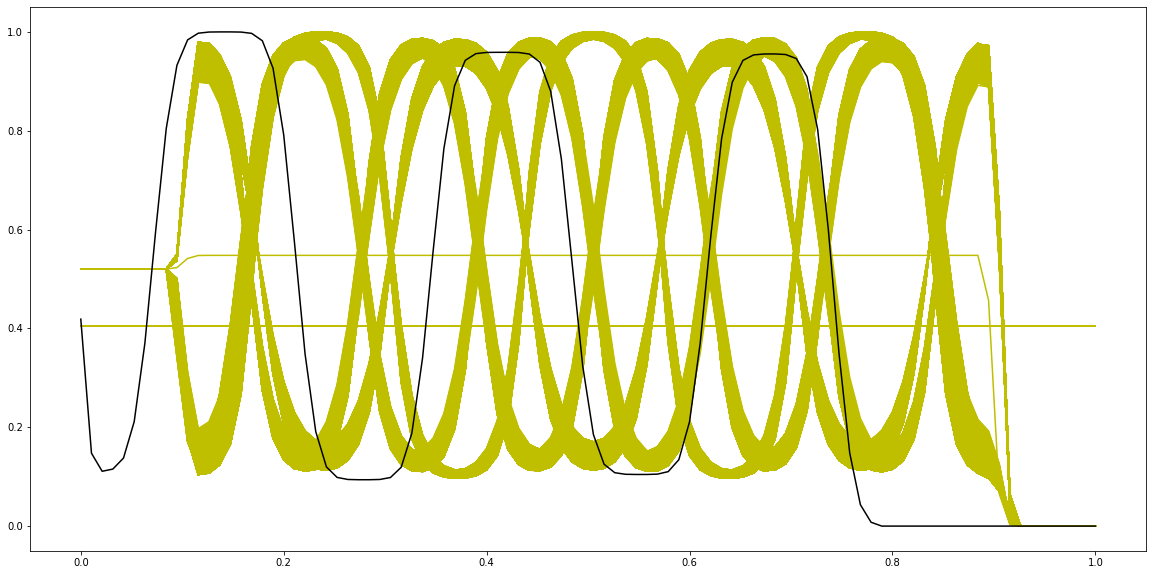

In [216]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0], sld_arr[x][1], 'y')
plt.plot(exp_sld_arr[0][0], exp_sld_arr[0][1], 'k')
#plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1], 'k') 
plt.show()